 # Прогнозирование оттока клиента Банка

**Цель**

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 
Построить модель с предельно большим значением *F1*-меры. Дополнительно измеряем *AUC-ROC*, сравнивая её значение с *F1*-мерой.

Описание данных
* `RowNumber` — индекс строки в данных
* `CustomerId` — уникальный идентификатор клиента
* `Surname` — фамилия
* `CreditScore` — кредитный рейтинг
* `Geography` — страна проживания
* `Gender` — пол
* `Age` — возраст
* `Tenure` — сколько лет человек является клиентом банка
* `Balance` — баланс на счёте
* `NumOfProducts` — количество продуктов банка, используемых клиентом
* `HasCrCard` — наличие кредитной карты
* `IsActiveMember` — активность клиента
* `EstimatedSalary` — предполагаемая зарплата

# Подготовка данных

## Изучение данных

In [1]:
# импортттируем необходимые библиотеки, алгоритмы, функции
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle

In [2]:
data = pd.read_csv('Churn.csv')
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Есть нарушение стиля названия заголовков. Необходимо привести к нижнему регистру и использовать змеиный регистр.

In [3]:
# общая информация о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В колонке `Tenure` есть пропуски. 

In [4]:
# приведем название колонок к нижнему регистру
data.columns = data.columns.str.lower()
data.head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
# изменим название колонок с учетом змеиного регистра
data = data.rename(columns={'rownumber':'row_number', 'customerid':'customer_id',
                            'creditscore':'credit_score', 'numofproducts':'num_of_products', 
                            'hascrcard':'has_cr_card','isactivemember':'is_active_member',
                            'estimatedsalary':'estimated_salary'})
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

### Вывод

1. В колонке `tenure` есть пропуски.
2. Обнаружены и исправлены нарушения стиля в названии колонок. 

## Предобработка данных

### Работа с пропусками в колонке `tenure`

In [6]:
# подсчитаем количество пропусков
data.tenure.isna().sum()

909

In [7]:
# посмотри уникальные значения в этой колонке
data.tenure.unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [8]:
# посмотрим на пропуски в данной колонке
data[data['tenure'].isna()]

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


Возможные варианты заполнения пропусков в колонке:
1. Сгруппировать по полу, возросту, стране и заполнить средним значением.
2. Удалить строки с пропущенными данными.
3. Заполнить медианным значением вне зависимоти от пола, возраста, страны.

Первый вариант подходит больше всего, так как он позваляет сохранить данных в других колонках, а заполнение пропущенных значений произвести более осознанно. Воспользуемся первым вариантом заполнения пропусков.

In [9]:
# Заполняем пропуски
data['tenure'] = data['tenure'].fillna(data
                                       .groupby(['gender', 'age', 'geography'])['tenure']
                                       .transform('mean'))
data['tenure'].isna().sum()

3

Осталось три незаполненых пропуска.

In [10]:
data[data['tenure'].isna()]

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
1678,1679,15569178,Kharlamov,570,France,Female,18,NaN,82767.42,1,1,0,71811.90,0
4556,4557,15796231,Nwankwo,681,France,Female,18,NaN,98894.39,1,1,1,9596.40,0
4644,4645,15714240,Ponomarev,712,Spain,Male,74,NaN,0.00,2,0,0,151425.82,0


Посмотрим сколько лет являются клиентами банка люди в возрасте 18 и 74 года.

In [11]:
display(data[data['age'] == 18].head(10))
display(data[data['age'] == 74].head(10))

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
746,747,15787619,Hsieh,844,France,Male,18,2.0,160980.03,1,0,0,145936.28,0
1619,1620,15770309,McDonald,656,France,Male,18,10.0,151762.74,1,0,1,127014.32,0
1678,1679,15569178,Kharlamov,570,France,Female,18,NaN,82767.42,1,1,0,71811.90,0
2021,2022,15795519,Vasiliev,716,Germany,Female,18,3.0,128743.80,1,0,0,197322.13,0
2136,2137,15621893,Bellucci,727,France,Male,18,4.0,133550.67,1,1,1,46941.41,0
2141,2142,15758372,Wallace,674,France,Male,18,7.0,0.00,2,1,1,55753.12,1
3330,3331,15657439,Chao,738,France,Male,18,4.0,0.00,2,1,1,47799.15,0
3512,3513,15657779,Boylan,806,Spain,Male,18,3.0,0.00,2,1,1,86994.54,0
3517,3518,15757821,Burgess,771,Spain,Male,18,1.0,0.00,2,0,0,41542.95,0
3686,3687,15665327,Cattaneo,706,France,Male,18,2.0,176139.50,2,1,0,129654.22,0


,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
888,889,15702968,Artemieva,733,Germany,Male,74,3.0,106545.53,1,1,1,134589.58,0
1055,1056,15769499,Lampungmeiua,545,Spain,Female,74,6.0,0.00,2,1,1,161326.73,0
1790,1791,15625641,Forbes,697,Germany,Female,74,3.0,108071.36,2,1,1,16445.79,0
1933,1934,15815560,Bogle,666,Germany,Male,74,7.0,105102.50,1,1,1,46172.47,0
2002,2003,15657214,Hsia,601,France,Male,74,2.0,0.00,2,0,1,51554.58,0
2012,2013,15780124,Blair,841,France,Male,74,9.0,108131.53,1,0,1,60830.38,0
2108,2109,15634949,Hay,593,Germany,Male,74,5.0,161434.36,2,1,1,65532.17,0
2433,2434,15718153,Kao,759,Spain,Female,74,6.0,128917.84,1,1,1,48244.64,0
3110,3111,15707596,Chung,546,Germany,Female,74,8.0,114888.74,2,1,1,66732.63,1
3366,3367,15684010,Tuan,640,Germany,Female,74,2.0,116800.25,1,1,1,34130.43,0


Оставшиеся 3 пропуска заполним средним значением сгруппированным по возрасту.

In [12]:
data['tenure'] = data['tenure'].fillna(data
                                       .groupby('age')['tenure']
                                       .transform('mean'))
data['tenure'].isna().sum()

0

### Вывод
 Пропуски в колонке `tenure` заполнены средним значением сгруппированным по возрасту, полу и региону проживания.

## Подготовка данных для обучения модели

Выделим общие признаки и целевой признак:

**Целевой признак**:

`exited` — факт ухода клиента

**Признаки:**
* `row_number` — индекс строки в данных
* `customer_id` — уникальный идентификатор клиента
* `surname` — фамилия
* `credit_score` — кредитный рейтинг
* `geography` — страна проживания
* `gender` — пол
* `age` — возраст
* `tenure` — сколько лет человек является клиентом банка
* `balance` — баланс на счёте
* `num_of_products` — количество продуктов банка, используемых клиентом
* `has_cr_card` — наличие кредитной карты
* `is_active_member` — активность клиента
* `estimated_salary` — предполагаемая зарплата

### Изучение корреляции между данными

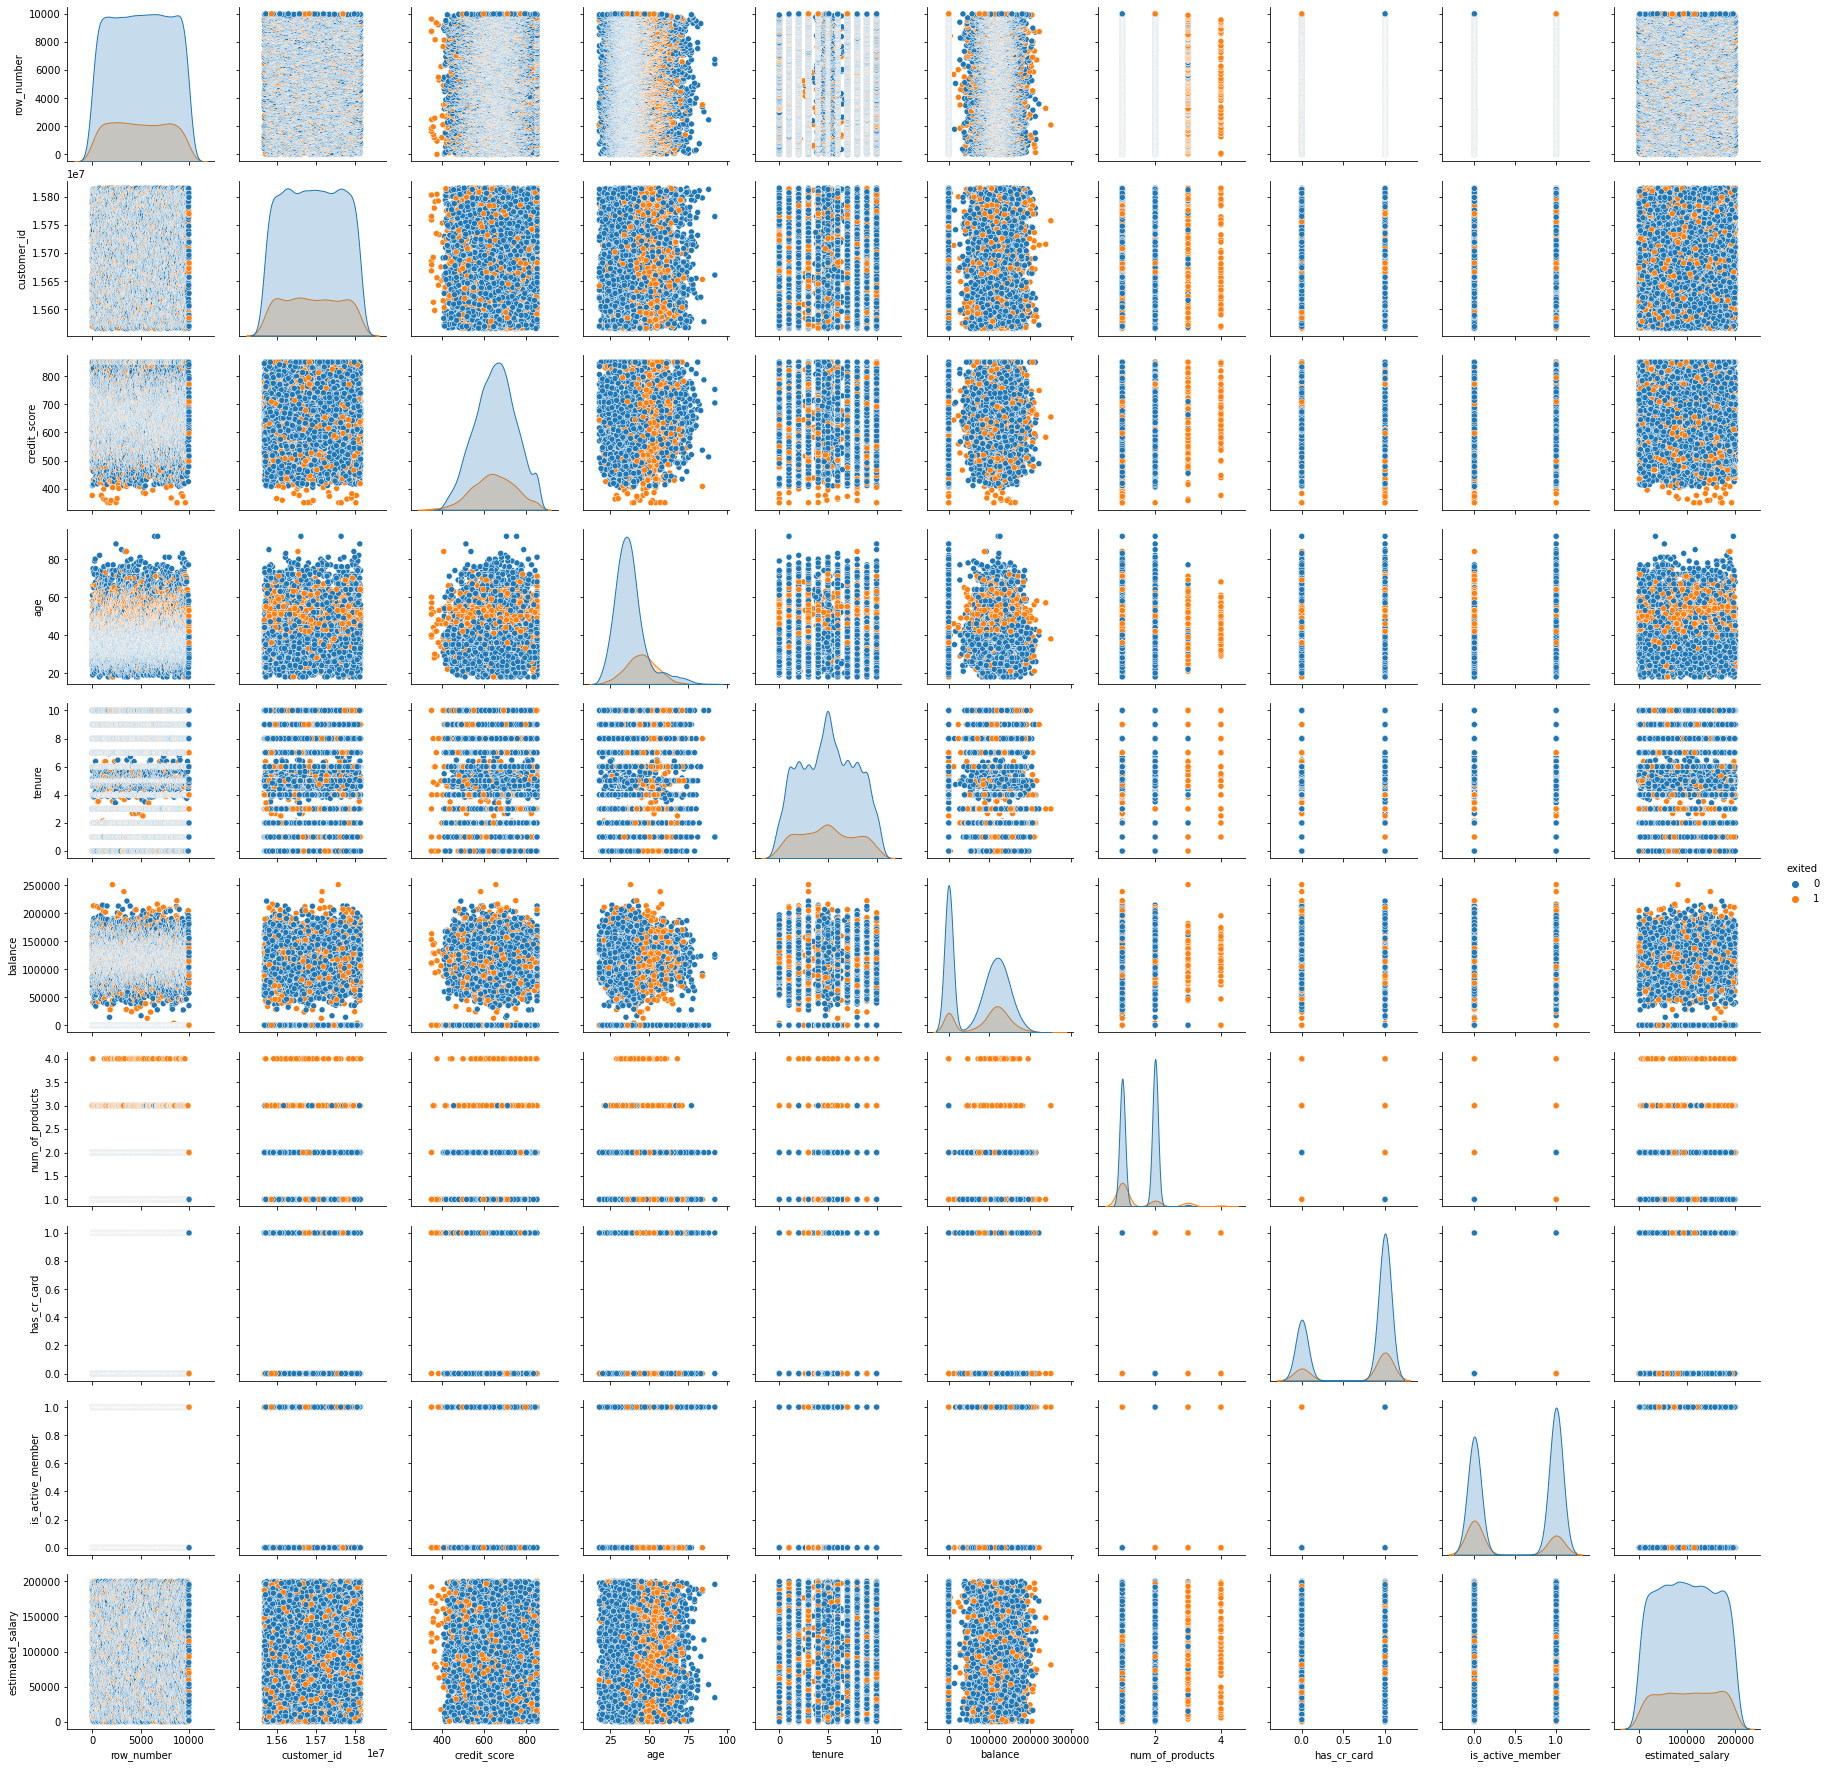

In [13]:
# Посмотрим есть ли корреляция в данных
sns.pairplot(data, hue='exited')

Исходя из полученных графиков видно, что клиентов, которые остались в банке больше, чем клиентов, которые ушли. Ярко выраженной зависимости между данными не наблюдается.

<AxesSubplot:>

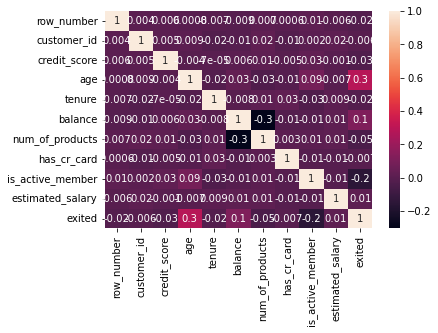

In [14]:
# Построим матрицу корреляции
sns.heatmap(data.corr(),annot = True, fmt = '.1g')

Самый большой коэффициент корреляции это 0.3 между возрастом и фактом ухода клиента из банка, и -0.3 между балансом клиента и количеством продуктов банка, которые он использует. Однако, величина такого коэффициента корреляции говорит о очень слабой корреляции между данными. Остальные коэффициенты корреляции близки к 0, что говорит что зависимости между этими данными нет.

### Разбиение на тренировочную и валидационную выборку

Столбецы `surname`, `row_number`, `customer_id` не влияет на целевой признак, а при преобразовании категориальных переменнх появяться лишние столбцы, поэтому удалим данную колонку.

In [15]:
# Удалим сттолбец surname
data = data.drop(['surname', 'row_number', 'customer_id'], axis=1)
data.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

Для преобразования категориальных переменных в численные используем метод One-Hot Encoding.

In [16]:
# воспользуемся техникой OHE для преобразования категориальных переменных
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.000000,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.000000,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.000000,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.000000,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.000000,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.000000,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.000000,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.000000,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.000000,75075.31,2,1,0,92888.52,1,1,0,1


In [17]:
# делим датасет на общие признаки и целевой
features = data_ohe.drop('exited', axis=1)
target = data_ohe['exited']

Изначально разделим исходный датасет на три выборки обучающую, валидационную, тестовую. В соотношении 3:1:1.

In [18]:
features_train, features_vt, target_train, target_vt  = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test  = train_test_split(
    features_vt, target_vt, test_size=0.5, random_state=12345)
    
print(f'Тренировочная выборка: {features_train.shape}')
print(f'Валидационная выборка: {features_valid.shape}')
print(f'Тестовая выборка: {features_test.shape}')    

Тренировочная выборка: (6000, 11)
Валидационная выборка: (2000, 11)
Тестовая выборка: (2000, 11)


Произведем маштабирование численных признаков, этот поможет в обучениее модели логистической регресии.

In [19]:
# маштабирование признаков 
pd.options.mode.chained_assignment = None
numeric = ['credit_score',
           'age', 
           'tenure', 
           'balance', 
           'estimated_salary', 
           'num_of_products',
          'geography_Germany',
          'geography_Spain',
          'gender_Male']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

# Исследование задачи

## Выбор модели

Будем рассматривать три модели:
1. Модель решающего дерева
2. Модель случайного леса
3. Модель логистичекой регрессии

Изначально обучим модель без подбора гиперпараметров и с учетом дисбаланса классов.

### Простейшая модель

Для проверки наших моделей на адекватность создадим простейшую модель с использованием DummyClassifier.

In [20]:
# функция позволяющая строить ROC-кривую
def curve(target, probabilities):
    fpr, tpr, thresholds = roc_curve(target, probabilities)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    return plt.show()

f-1: 0.0
auc_roc: 0.5


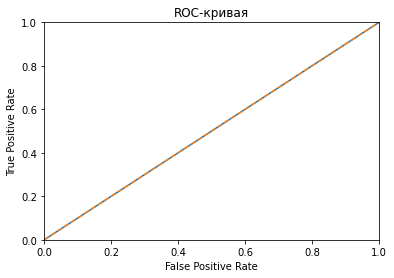

In [21]:
# Элементарная модель
model_random = DummyClassifier(random_state=12345, strategy='most_frequent')
model_random.fit(features_train,target_train)
predictions = model_random.predict(features_valid)
f1 = f1_score(target_valid, predictions)
print(f'f-1: {f1}')

probabilities_valid = model_random.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print(f'auc_roc: {roc_auc_score(target_valid, probabilities_one_valid)}')
curve(target_valid, probabilities_one_valid)

Для такой модели метрика f-1 равно 0, а AUC-ROC равна 0.5

### Модель решающего дерева

f-1: 0.49759615384615385
auc_roc: 0.6821841409638335


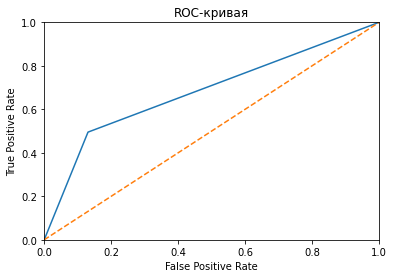

In [22]:
# Модель решающего дерева без учета гиперпараметров
model_tree = DecisionTreeClassifier(random_state=12345)
model_tree.fit(features_train, target_train)
predict_valid = model_tree.predict(features_valid)
print(f'f-1: {f1_score(target_valid, predict_valid)}')

probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print(f'auc_roc: {roc_auc_score(target_valid, probabilities_one_valid)}')
curve(target_valid, probabilities_one_valid)

Для решающего дерева без учета гиперпараметров метрика **F-1** равна **0.509**, а **АUC_ROC** - **0.691**.

Напишем функцию, которая позволит подобрать гиперпараметры для модели решающего дерева.

In [23]:
# Функция для модели решающего дерева
def get_metrics_for_model_tree(features, target, class_weight=None):
    model_params = {
        'random_state': 12345,
        'class_weight': class_weight,
   }        
    model = DecisionTreeClassifier(**model_params)
    
    parametrs = {
        'max_depth': range (1,10),
        'min_samples_leaf': range (2,4),
        'min_samples_split': range (2,4),
     }
    
    model_1 = GridSearchCV(model, parametrs, cv=3)
    model_1.fit(features, target)
    print(model_1.best_estimator_)
    predictions_tree = model_1.predict(features_valid)
    f1 = f1_score(target_valid, predictions_tree)
    print(f'f-1: {f1}')

    probabilities_valid = model_1.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print(f'auc_roc: {auc_roc}')
    curve(target_valid, probabilities_one_valid)
    return f1, auc_roc

DecisionTreeClassifier(max_depth=6, min_samples_leaf=2, random_state=12345)
f-1: 0.5727272727272728
auc_roc: 0.8246450801178328


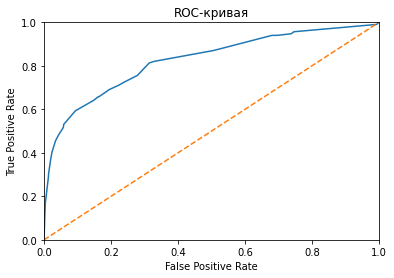

(0.5727272727272728, 0.8246450801178328)

In [24]:
# Вызываем функцию get_metrics_for_model_tree
get_metrics_for_model_tree(features_train, target_train)

Для решающего дерева с учетом гиперпараметров метрика **F-1** равна **0.564**, а **АUC_ROC** - **0.819**.
Гиперпараметры позволили увеличить метрику **F-1** на 0.055. С увеличением метрики **F-1** увеличивается и АUC_ROC.

### Модель случайного леса

f-1: 0.5752608047690015
auc_roc: 0.8423623418965757


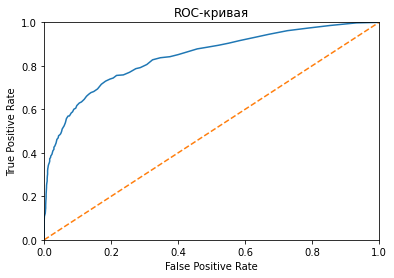

In [24]:
# Модель случайного леса без учета гиперпараметров
model_forest = RandomForestClassifier(random_state=12345)
model_forest.fit(features_train, target_train)
predictions_forest = model_forest.predict(features_valid)
print(f'f-1: {f1_score(target_valid, predictions_forest)}')

probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print(f'auc_roc: {roc_auc_score(target_valid, probabilities_one_valid)}')
curve(target_valid, probabilities_one_valid) 

Для случайного леса без учетом гиперпараметров метрика **F-1** равна **0.571**, а **АUC_ROC** - **0.84**.

Модель случайного леса без учета гиперпараметров лучше, чем модель решающего дерева с учетом гиперпараметров.

Напишем функцию, которая позволит подобрать гиперпараметры для модели случайного леса.

In [25]:
def get_metrics_for_model_forest(features, target, class_weight=None):
    model_params = {
        'random_state': 12345,
        'class_weight': class_weight,
   }        
    model = RandomForestClassifier(**model_params)
    
    parametrs = {
        'max_depth': range (1,10),
        'n_estimators': range (50, 120, 10),
     }
    
    model_1 = GridSearchCV(model, parametrs, cv=3)
    model_1.fit(features, target)
    print(model_1.best_estimator_)
    predictions_tree = model_1.predict(features_valid)
    f1 = f1_score(target_valid, predictions_tree)
    print(f'f-1: {f1}')

    probabilities_valid = model_1.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print(f'auc_roc: {auc_roc}')
    curve(target_valid, probabilities_one_valid)
    best_model = model_1.best_estimator_
    return f1, auc_roc, best_model

RandomForestClassifier(max_depth=9, random_state=12345)
f-1: 0.5638629283489096
auc_roc: 0.8535785360424393


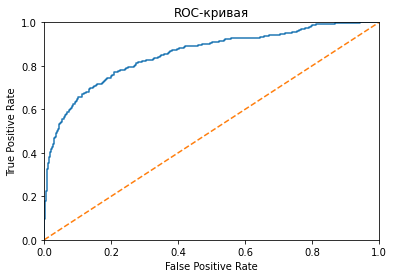

(0.5638629283489096,
 0.8535785360424393,
 RandomForestClassifier(max_depth=9, random_state=12345))

In [26]:
# вызываем функцию get_metrics_for_model_forest
get_metrics_for_model_forest(features_train, target_train)

Модель с гиперпараметрами, при которых метрика F-1 больше сохранили в переменную best_model. 

Для случайного леса с учетом гиперпараметров метрика **F-1** равна **0.537**, а **АUC_ROC** - **0.847**. 


### Модель логистической регресии

Напишем функции, которая позволит, обучить модель логистической регресии и подобрать параметры.

In [27]:
def get_metrics_for_model_regression(features, target, class_weight=None):
    model_params = {
        'random_state': 12345,
        'class_weight': class_weight,
        'solver': 'liblinear',
   }        
    model = LogisticRegression(**model_params)
    model.fit(features, target)
    predictions_regression = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_regression)
    print(f'f-1: {f1}')

    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print(f'auc_roc: {auc_roc}')
    curve(target_valid, probabilities_one_valid)
    
    return f1, auc_roc

f-1: 0.33108108108108103
auc_roc: 0.7586454067590538


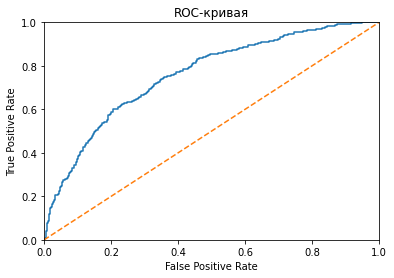

(0.33108108108108103, 0.7586454067590538)

In [28]:
# вызываем функцию get_metrics_for_model_regression
get_metrics_for_model_regression(features_train, target_train)

Для модели логистической регресии метрика **F-1** очень мала и стремится к 0, а **АUC_ROC** - **0.493**. 

# Баланс классов

Посмотрим существует ли дисбаланс классов в нашем случае. Изучая корреляцию между данными мы уже видели, что преобладает класс со значением 0, подтвердим это.

0    7963
1    2037
Name: exited, dtype: int64
0    0.800667
1    0.199333
Name: exited, dtype: float64


/Users/daivanov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


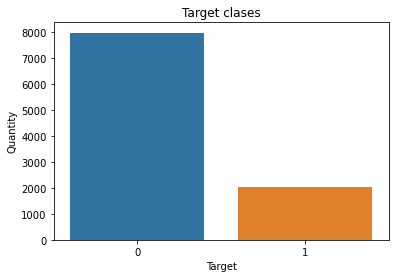

In [37]:
sns.countplot(target)
plt.title('Target clases')
plt.xlabel('Target')
plt.ylabel('Quantity')
print(target.value_counts())
print(target_train.value_counts(normalize=True))

Мы видем, что класс cо значением 0 значительно преобладает, что приводит к дисбалансу классов.

### Взвешивание классов

Что бы избежать дисбаланса классов предадим объектам редкого класса больший вес, используя параметр
**class_weight='balanced'**.

DecisionTreeClassifier(class_weight='balanced', max_depth=3, min_samples_leaf=3,
                       random_state=12345)
f-1: 0.541015625
auc_roc: 0.7980472601455368


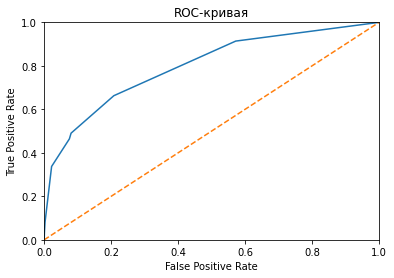

(0.541015625, 0.7980472601455368)

In [38]:
# вызов функции get_metrics_for_model_tree с учетом параметра class_weigh
get_metrics_for_model_tree(features_train, target_train, class_weight='balanced')

RandomForestClassifier(class_weight='balanced', max_depth=9, random_state=12345)
f-1: 0.6238532110091742
auc_roc: 0.8551104228794029


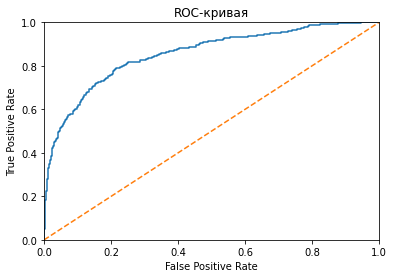

(0.6238532110091742,
 0.8551104228794029,
 RandomForestClassifier(class_weight='balanced', max_depth=9, random_state=12345))

In [39]:
# вызов функции get_metrics_for_model_forest с учетом параметра class_weigh
get_metrics_for_model_forest(features_train, target_train, class_weight='balanced')

f-1: 0.4901456726649529
auc_roc: 0.7637446391521847


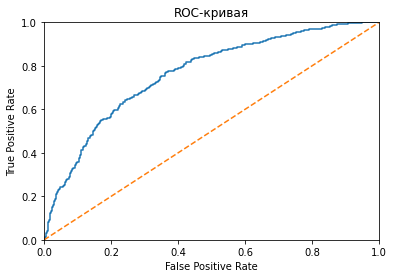

(0.4901456726649529, 0.7637446391521847)

In [40]:
# вызов функции get_metrics_for_model_regression с учетом параметра class_weigh
get_metrics_for_model_regression(features_train, target_train, class_weight='balanced')

**Вывод** аргумент class_weight со значение balanced позволил увеличить значение метрик для модели случаного леса и логистической регрессии. В случае модели решающего дерева auc_roc уменьшилась с 0.819 до 0.798, но так же упала и метрика F-1. Для модели случайный лес и линейная регресия с увеличением F-1 увеличилась и auc_roc. Особенно значительно auc_roc увеличилась для модели линейной регресии

### Увеличение выборки

In [41]:
# Функция позволяющая увеличить число редких значений в целевом признаке
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
# Объединяем
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
# Перемешиваем 
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

AxesSubplot(0.125,0.125;0.775x0.755)
0    0.501043
1    0.498957
Name: exited, dtype: float64


/Users/daivanov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


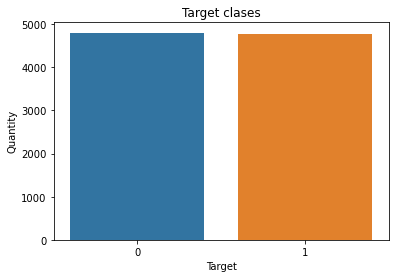

In [44]:
# вызываем функцию upsample
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
# Проверим, что количество классов сравнялось
print(sns.countplot(target_upsampled));
plt.title('Target clases')
plt.xlabel('Target')
plt.ylabel('Quantity')
print(target_upsampled.value_counts(normalize=True))

Доля классов в целевом признаки практически одинакова.

DecisionTreeClassifier(max_depth=9, min_samples_leaf=2, random_state=12345)
f-1: 0.5339712918660287
auc_roc: 0.775126422250316


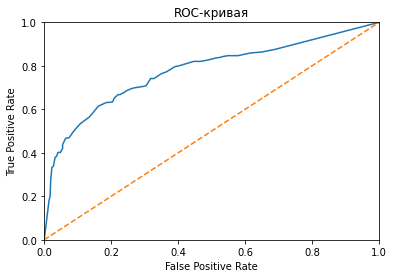

(0.5339712918660287, 0.775126422250316)

In [45]:
#вызываем функцию подбора гиперпараметров для решающего дерева с учетом баланса классов в целевом признаке
get_metrics_for_model_tree(features_upsampled, target_upsampled)

RandomForestClassifier(max_depth=9, n_estimators=90, random_state=12345)
f-1: 0.6186440677966102
auc_roc: 0.8540518633671871


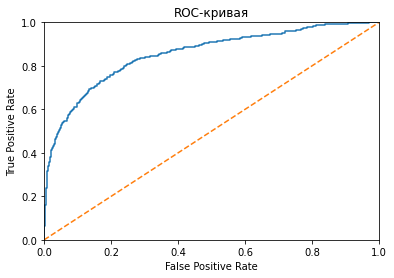

In [46]:
#вызываем функцию подбора гиперпараметров для модели случайного леса 
_, _, final_model = get_metrics_for_model_forest(features_upsampled, target_upsampled)

Для модели случайного леса с увеличеннвм количеством редких значений в целевом признаке метрика F-1 достигла 0,619. Модель с такими параметрами была сохранена в переменную final_model.

f-1: 0.4888507718696398
auc_roc: 0.7636917111765739


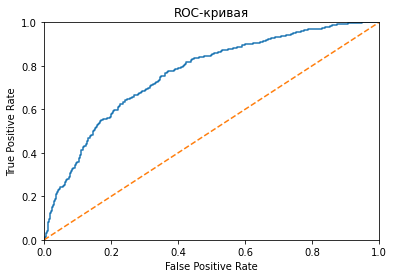

(0.4888507718696398, 0.7636917111765739)

In [47]:
#вызываем функцию подбора гиперпараметров для модели линейной регресии 
#с учетом баланса классов в целевом признаке
get_metrics_for_model_regression(features_upsampled, target_upsampled)

### Уменьшение выборки

In [48]:
# функция позволяющая уменьшить количество часто встречающих значений 
#до количества редко встречающихся значений
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
 # Перемешиваем   
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

AxesSubplot(0.125,0.125;0.775x0.755)
0    0.501043
1    0.498957
Name: exited, dtype: float64


/Users/daivanov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


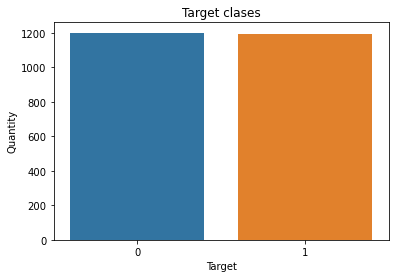

In [49]:
# вызов функции downsample
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
# Проверим, что количество классов сравнялось
print(sns.countplot(target_downsampled));
plt.title('Target clases')
plt.xlabel('Target')
plt.ylabel('Quantity')
print(target_downsampled.value_counts(normalize=True))

DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, random_state=12345)
f-1: 0.5957011258955988
auc_roc: 0.8280400316962964


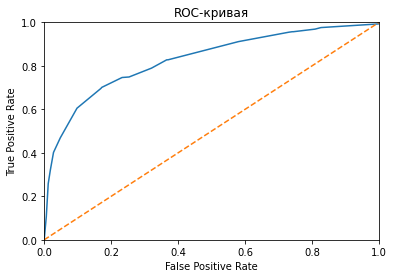

(0.5957011258955988, 0.8280400316962964)

In [50]:
# вызов функции get_metrics_for_model_tree с учетом уменьшеной выборки
get_metrics_for_model_tree(features_downsampled, target_downsampled)

RandomForestClassifier(max_depth=8, n_estimators=50, random_state=12345)
f-1: 0.590009425070688
auc_roc: 0.847829045663233


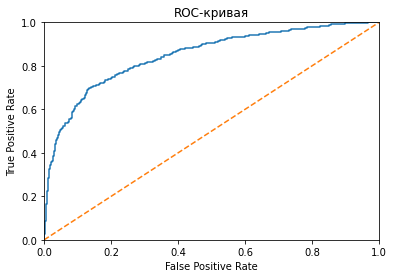

(0.590009425070688,
 0.847829045663233,
 RandomForestClassifier(max_depth=8, n_estimators=50, random_state=12345))

In [51]:
# вызов функции get_metrics_for_model_forest с учетом уменьшеной выборки
get_metrics_for_model_forest(features_downsampled, target_downsampled)

f-1: 0.48578811369509034
auc_roc: 0.762208215631597


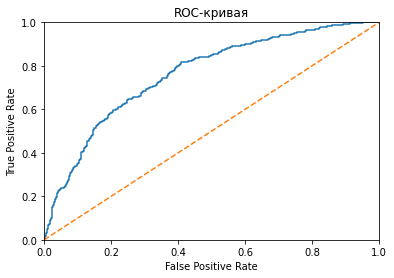

(0.48578811369509034, 0.762208215631597)

In [52]:
# вызов функции get_metrics_for_model_regression с учетом уменьшеной выборки
get_metrics_for_model_regression(features_downsampled, target_downsampled)

### Изменение порога

In [53]:
probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1_max = 0
max_threshold = 0
for threshold in np.arange(0.2, 0.8, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    #print("При пороге {:.2f} - f1 равно {:.2f}".format(threshold, f1))
    if f1 > f1_max:
        f1_max= f1
        max_threshold = threshold
print("При пороге {:.2f} - f1 максимально {:.3f}".format(threshold, f1_max))

При пороге 0.80 - f1 максимально 0.498


In [54]:
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1_max = 0
max_threshold = 0
for threshold in np.arange(0.2, 0.8, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    #print("При пороге {:.2f} - f1 равно {:.2f}".format(threshold, f1))
    if f1 > f1_max:
        f1_max= f1
        max_threshold = threshold
print("При пороге {:.2f} - f1 максимально {:.3f}".format(threshold, f1_max))

При пороге 0.80 - f1 максимально 0.621


In [55]:
model_regression = LogisticRegression(random_state=12345)
model_regression.fit(features_train, target_train)

probabilities_valid = model_regression.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1_max = 0
max_threshold = 0
for threshold in np.arange(0.2, 0.8, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    #print("При пороге {:.2f} - f1 равно {:.2f}".format(threshold, f1))
    if f1 > f1_max:
        f1_max= f1
        max_threshold = threshold
print("При пороге {:.2f} - f1 максимально {:.3f}".format(threshold, f1_max))

При пороге 0.80 - f1 максимально 0.499


При изменении порога значительных улучшений в метриках по сравнению с метриками, полученными в предыдущих подходах, не произошло. 

# Тестирование модели

Самую высокую метрику F-1 показала модель случайного леса с увеличенной выборкой и гиперпараметрами глубина 9, кличество деревьев 70. Проведем тестирование этой модели.

Перед тестированием объединим тренировочную и валидационную выборку.

/Users/daivanov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Quantity')

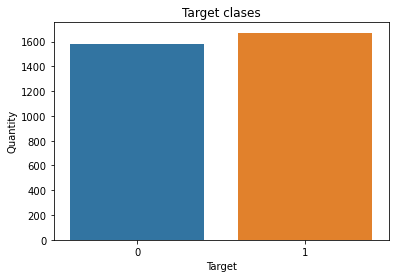

In [57]:
# увеличим валидационную выборку, что бы ее можно было объеденить с тренировочной
features_upsampled_valid, target_upsampled_valid = upsample(features_valid, target_valid, 4)
sns.countplot(target_upsampled_valid)
plt.title('Target clases')
plt.xlabel('Target')
plt.ylabel('Quantity')

In [58]:
# объединение тренировочной и валидационной выборки
features_train_join = pd.concat([features_upsampled_valid, features_upsampled])
target_train_join  = pd.concat([target_upsampled_valid, target_upsampled])

f-1: 0.6136125654450262
auc_roc: 0.8570227157229141


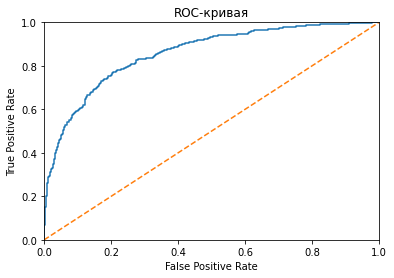

In [59]:
# Обучение модели случайного леса и ее тестирование на тестовой выборке
model_forest = RandomForestClassifier(random_state=12345, max_depth = 9, n_estimators= 90)
model_forest.fit(features_train_join, target_train_join)
predict_valid = model_forest.predict(features_test)
print(f'f-1: {f1_score(target_test, predict_valid)}')

probabilities_valid = model_forest.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
print(f'auc_roc: {roc_auc_score(target_test, probabilities_one_valid)}')
curve(target_test, probabilities_one_valid)

При использование такой обучающей выборки метрики F-1 и auc_roc достигли 0.614 и 0.857 соответственно в тестовой выборке. 

f-1: 0.6068111455108358
auc_roc: 0.8563436275898668


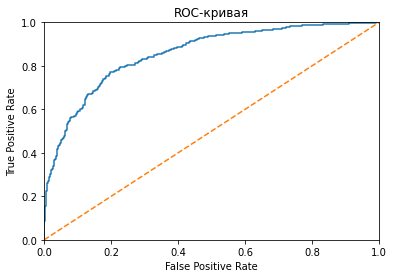

In [60]:
# тестирование модели
predict_test = final_model.predict(features_test)
print(f'f-1: {f1_score(target_test, predict_test)}')

probabilities_test = final_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print(f'auc_roc: {roc_auc_score(target_test, probabilities_one_test)}')
curve(target_test, probabilities_one_test) 

Значение метрик, полученной модели, значительно превышают значения метрик элементарной модели. На тестовой выборки значение метрики не сильно отличается от значения метрики на валидационной выборки, следовательно модель не переобучилась. 

Данная модель показала хорошие значения метрик на тестовой выборке.

На кривой ошибок видно, что наша модель работает лучше, чем модель выдающая случайные значения.

# Вывод 

Наилучшей моделью окозалась модель случайного леса с глубиной 9 и количеством деревьев 90. Оптимальным решением проблемы  дисбаланса является увеличение выборки. Метрика F-1 для такой модели на тестовой выборке составила 0.612, а auc_roc - 0.855.

При обучении модели так же хорошие результаты показала модель случайный лес при использовании параметра class_weight='balanced'.

Объединим данные для всех обученных моделей в датафреймы.

In [61]:
# модель решающего дерева
name = ['simple_tree','tree_hyperparameters', 
        'tree_class_weight', 
        'tree_upsampling', 
        'tree_downsample', 
       'tree_threshold']
F_1 = [0.509, 0.564, 0.541, 0.524, 0.598, 0.509]
AUC_ROC = [0.69, 0.819, 0.798, 0.772, 0.831, None]

tree = pd.DataFrame({'model': name, 'F-1': F_1, 'AUC_ROC':AUC_ROC})
tree

,model,F-1,AUC_ROC
0,simple_tree,0.509,0.690
1,tree_hyperparameters,0.564,0.819
2,tree_class_weight,0.541,0.798
3,tree_upsampling,0.524,0.772
4,tree_downsample,0.598,0.831
5,tree_threshold,0.509,NaN


In [62]:
# модель случайного леса
name = ['simple_forest','forest_hyperparameters', 
        'forest_class_weight', 
        'forest_upsampling', 
        'forest_downsample', 
       'forest_threshold']
F_1 = [0.571, 0.537, 0.619, 0.619, 0.579, 0.62]
AUC_ROC = [0.84, 0.847, 0.854, 0.854, 0.842, None]

forest = pd.DataFrame({'model': name, 'F-1': F_1, 'AUC_ROC':AUC_ROC})
forest

,model,F-1,AUC_ROC
0,simple_forest,0.571,0.840
1,forest_hyperparameters,0.537,0.847
2,forest_class_weight,0.619,0.854
3,forest_upsampling,0.619,0.854
4,forest_downsample,0.579,0.842
5,forest_threshold,0.620,NaN


In [53]:
# модель логистической регресии
name = ['simple_regression', 
        'regression_class_weight', 
        'regression_upsampling', 
        'regression_downsample', 
       'regression_threshold']
F_1 = [0, 0.488, 0.29, 0.29, 0.248]
AUC_ROC = [0.493, 0.763, 0.496, 0.496, 0.248]

regression = pd.DataFrame({'model': name, 'F-1': F_1, 'AUC_ROC':AUC_ROC})
regression

,model,F-1,AUC_ROC
0,simple_regression,0.000,0.493
1,regression_class_weight,0.488,0.763
2,regression_upsampling,0.290,0.496
3,regression_downsample,0.290,0.496
4,regression_threshold,0.248,0.248


При увеличении метрики F-1 увеличивается и метрика AUC_ROC.